In [1]:
# Library Imports
import os
import warnings

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.display
import torchaudio
from IPython.display import Audio

# PyTorch & Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader

# Transformers & Model Training
from transformers import (
    Wav2Vec2Model,
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Sckit Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Suppress Warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/audio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
torch.manual_seed(42)

## Dataset

In [4]:
paths = []
labels = []

data_dir = "../../data/"
max_files = 6000

for root, _, files in os.walk(data_dir):
    for file in files:
        paths.append(os.path.join(root, file))
        label = file.rsplit("_", 1)[-1].split(".")[0].lower()
        labels.append(label)

        if len(paths) >= max_files:
            break
    if len(paths) >= max_files:
        break

In [5]:
print(f"Total number of files processed: {len(paths)}")

Total number of files processed: 5600


In [6]:
print("First 5 labels:", labels[:5])

unique_labels = set(labels)
print(f"Unique labels ({len(unique_labels)}): {unique_labels}")

First 5 labels: ['disgust', 'disgust', 'disgust', 'disgust', 'disgust']
Unique labels (7): {'sad', 'happy', 'ps', 'disgust', 'fear', 'neutral', 'angry'}


In [7]:
audio_df = pd.DataFrame({"audio_paths": paths, "labels": labels})

In [8]:
audio_df["labels"].value_counts()

labels
disgust    800
ps         800
happy      800
sad        800
neutral    800
fear       800
angry      800
Name: count, dtype: int64

### Exploratory Data Analysis

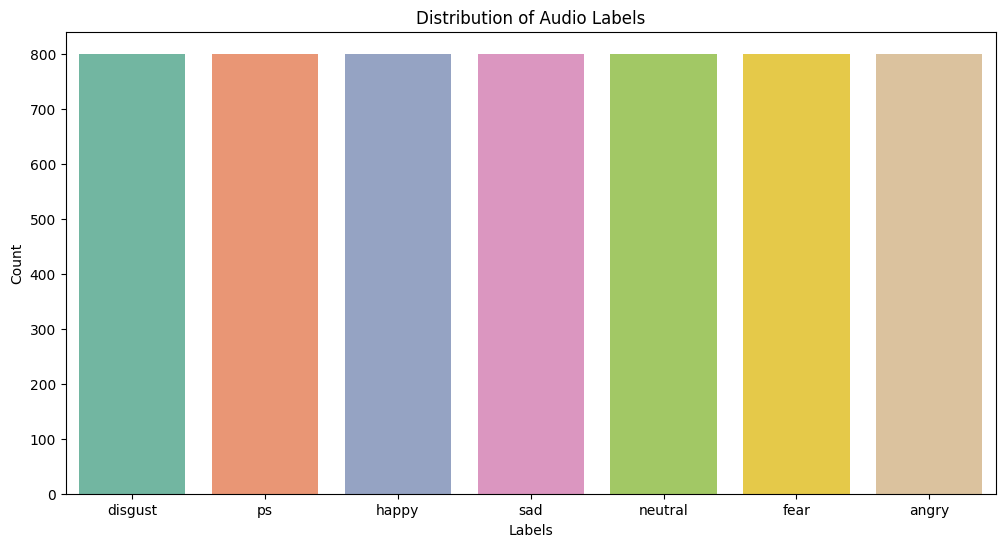

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=audio_df, x="labels", order=audio_df["labels"].value_counts().index, palette="Set2")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Audio Labels")
plt.show()

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveform - {emotion}", fontsize=20)
    librosa.display.waveshow(data, sr=sr, color="#1e90ff")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(f"Spectrogram - {emotion}", fontsize=20)
    librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="log", cmap="magma")
    plt.colorbar(label="Decibels (dB)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

In [11]:
def plot_audio_and_play(path, emotion):
    data, sampling_rate = librosa.load(path)
    
    waveplot(data, sampling_rate, emotion)
    spectrogram(data, sampling_rate, emotion)
    return Audio(path)


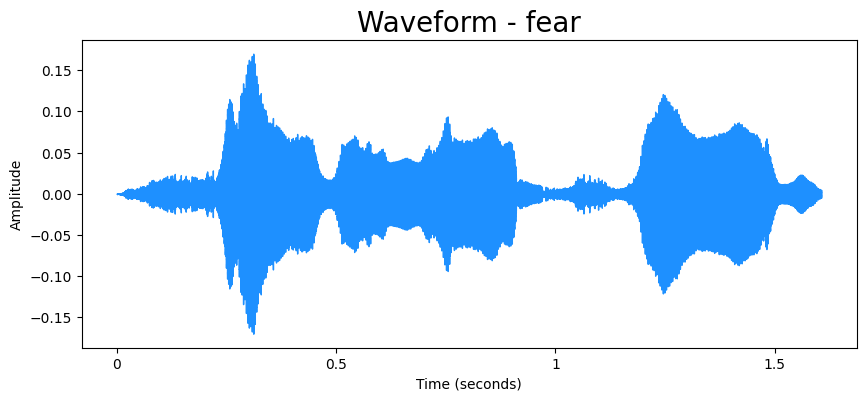

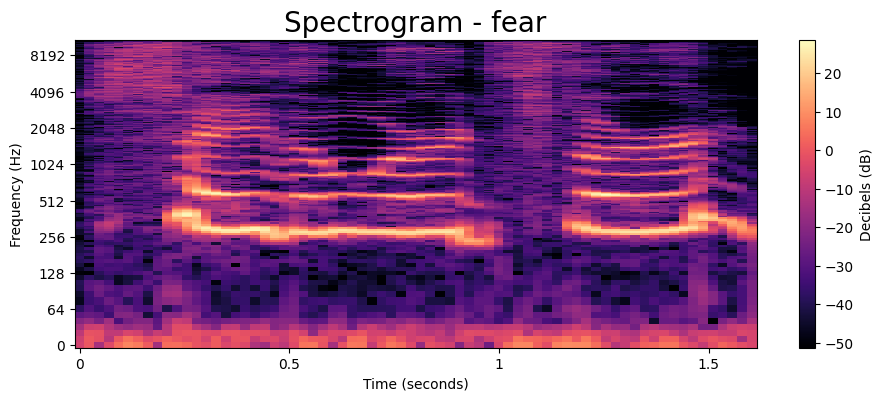

In [12]:
emotion = "fear"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

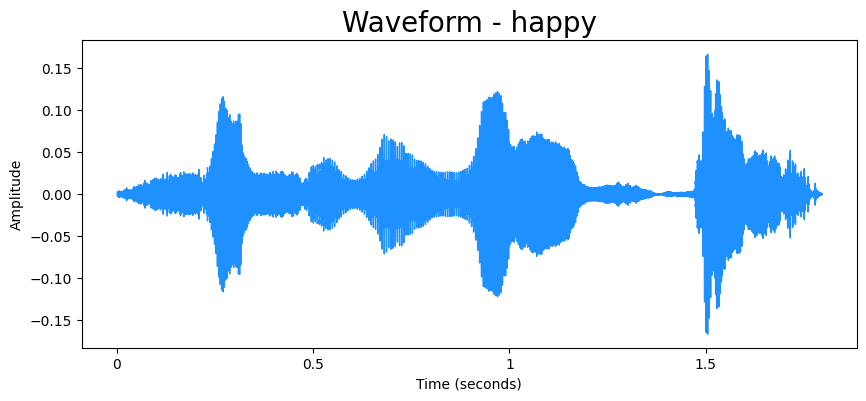

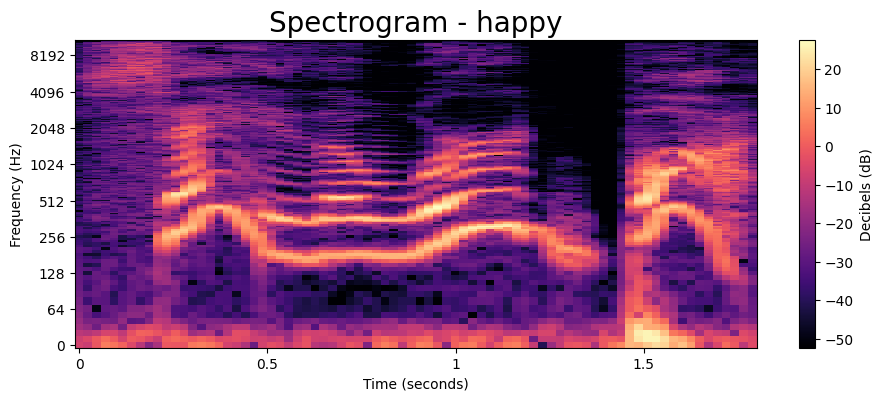

In [13]:
emotion = "happy"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

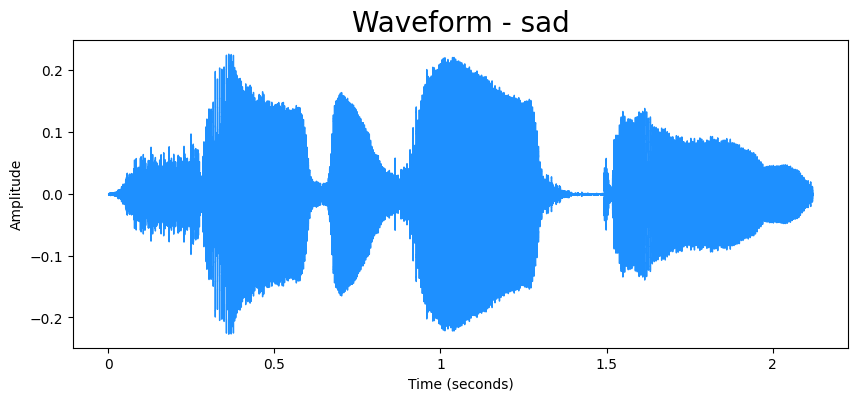

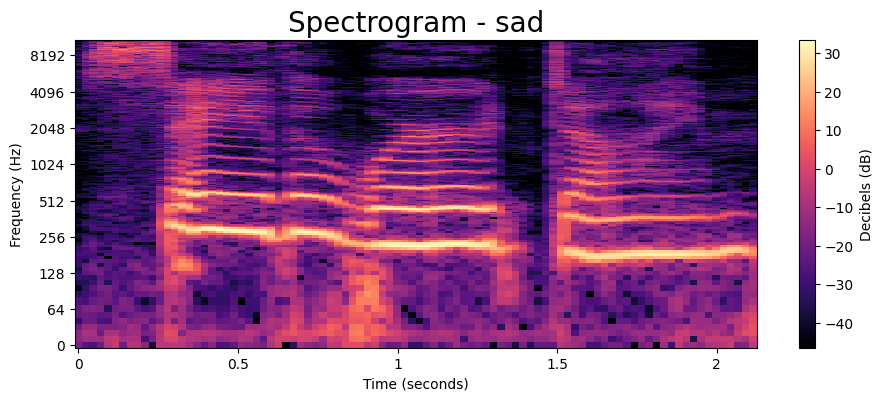

In [14]:
emotion = "sad"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

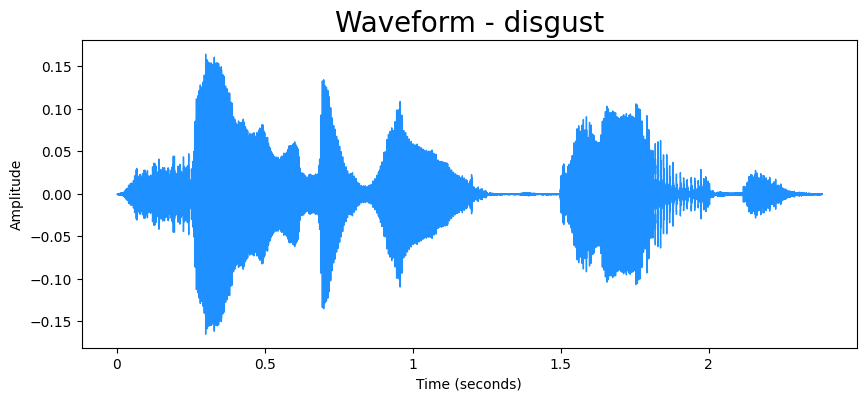

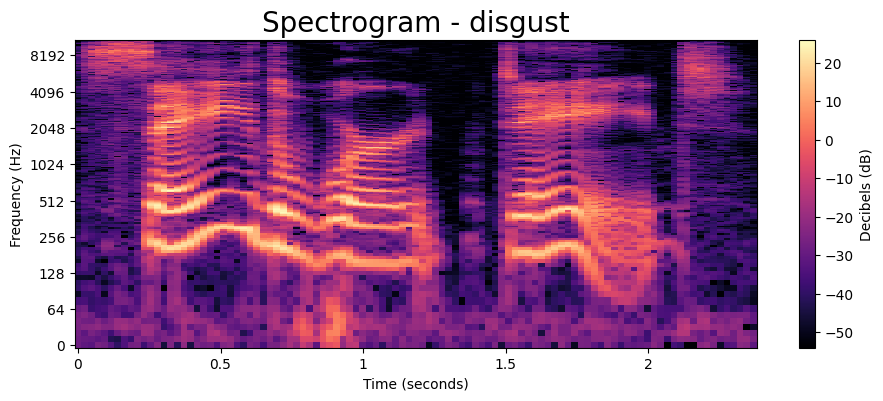

In [15]:
emotion = "disgust"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

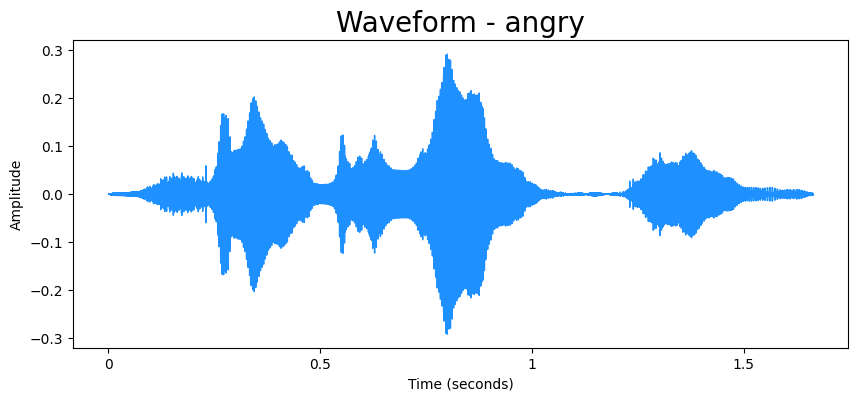

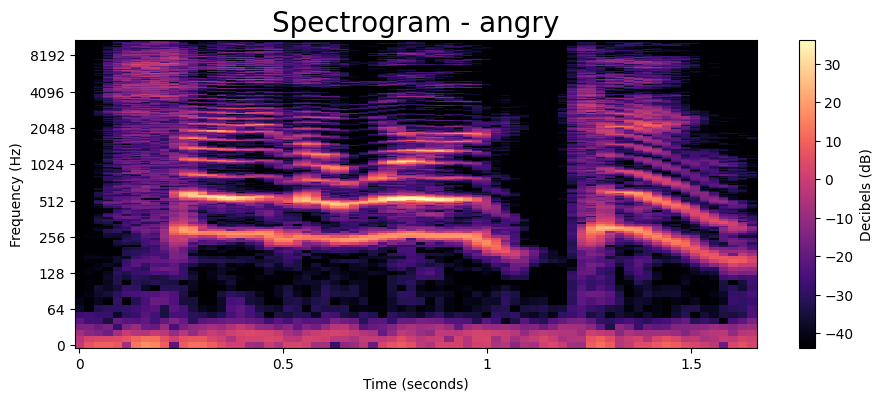

In [16]:
emotion = "angry"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

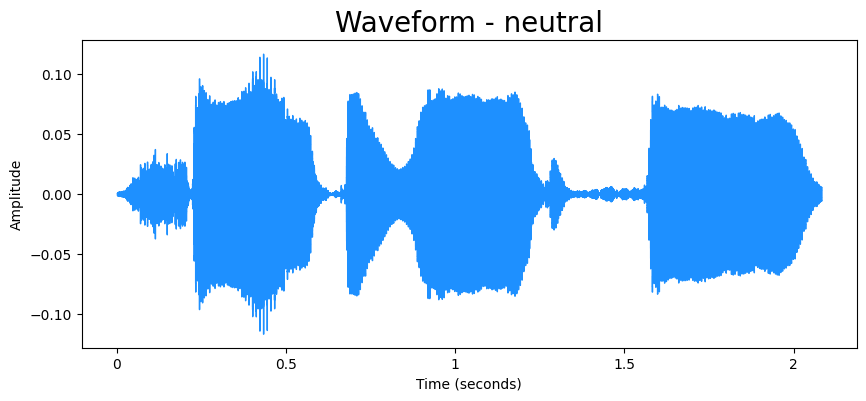

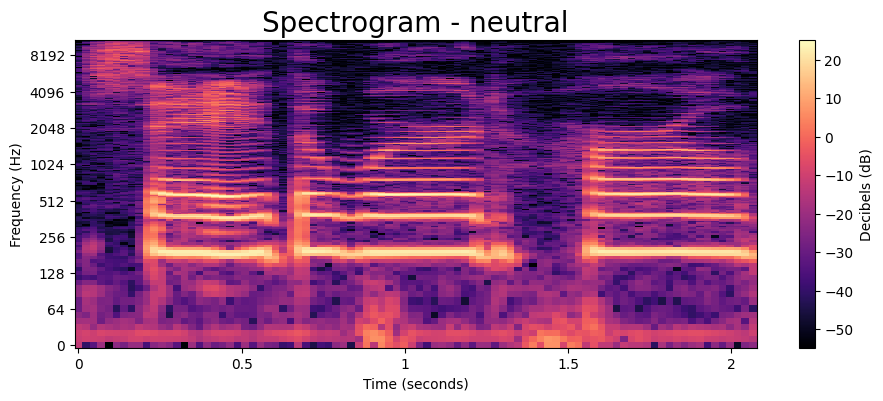

In [17]:
emotion = "neutral"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

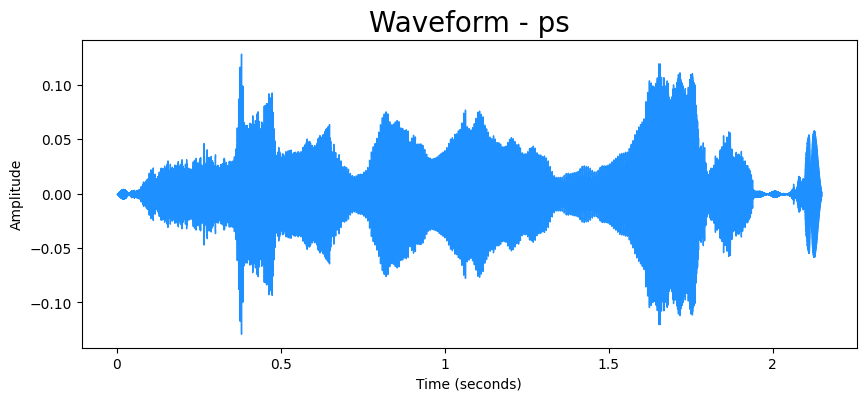

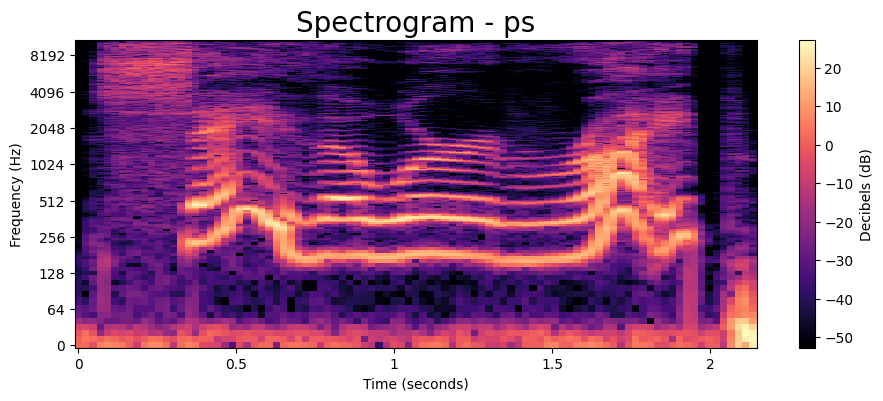

In [18]:
emotion = "ps"
path = np.array(audio_df["audio_paths"][audio_df["labels"] == emotion])[0]
plot_audio_and_play(path, emotion)

## Custom Dataset Class

In [19]:
# we need to convert labels to integers
label_encoder = LabelEncoder()

audio_df["encoded_labels"] = label_encoder.fit_transform(audio_df["labels"])

In [20]:
audio_df.head()

,audio_paths,labels,encoded_labels
0,../../data/TESS Toronto emotional speech set d...,disgust,1
1,../../data/TESS Toronto emotional speech set d...,disgust,1
2,../../data/TESS Toronto emotional speech set d...,disgust,1
3,../../data/TESS Toronto emotional speech set d...,disgust,1
4,../../data/TESS Toronto emotional speech set d...,disgust,1


In [21]:
audio_df["encoded_labels"].value_counts()

encoded_labels
1    800
5    800
3    800
6    800
4    800
2    800
0    800
Name: count, dtype: int64

In [22]:
emotion = "ps"
path = audio_df["audio_paths"][audio_df["labels"] == emotion].iloc[0]

data, sr = librosa.load(path)

print(f"Length of audio data: {len(data)} samples")
print(f"Audio duration (in samples): {sr}")

Length of audio data: 47389 samples
Audio duration (in samples): 22050


In [23]:
class SpeechEmotionDataset(Dataset):
    """
    A PyTorch Dataset for loading and processing speech emotion data for classification tasks.
    """
    
    def __init__(self, df, processor, max_length=44100):
        """
        Initializes the dataset by storing the DataFrame, processor, and the maximum length for audio samples.
        
        Args:
            df (pandas.DataFrame): DataFrame containing the paths to the audio files and the corresponding labels.
            processor (callable): The processor for transforming the audio data into model-ready inputs.
            max_length (int): Maximum length for padding/truncating the audio samples.
        """
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Retrieves an audio sample and its corresponding label at a specified index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing:
                - "input_values" (torch.Tensor): Processed audio input values ready for model input.
                - "labels" (torch.Tensor): The label of the audio sample (encoded as an integer).
        """
        # the audio path and label for the current index
        audio_path = self.df.iloc[index]["audio_paths"]
        label = self.df.iloc[index]["encoded_labels"]

        # the speech file
        speech, sr = librosa.load(audio_path, sr=16000)

        # the length of speech does not exceed max_length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            # padding the speech data with zeros if it's shorter than max_length
            speech = np.pad(speech, (0, self.max_length - len(speech)), mode="constant")

        inputs = self.processor(speech, sampling_rate=sr, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()

        return {"input_values": input_values, "labels": torch.tensor(label, dtype=torch.long)}

In [24]:
train_df, test_df = train_test_split(audio_df, test_size=0.2, random_state=42)

In [25]:
# Initializing the processor and the model

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [27]:
# loading the dataset

train_dataset = SpeechEmotionDataset(train_df, processor=processor)
test_dataset = SpeechEmotionDataset(test_df, processor=processor)

In [28]:
print(f"Length of the dataset: {len(train_dataset)}")

first_item = train_dataset[0]
print(f"First item details: {first_item}")

print(f"Input Values (audio data): {first_item['input_values']}")
print(f"Label: {first_item['labels']}")

Length of the dataset: 4480
First item details: {'input_values': tensor([ 0.0020, -0.0042, -0.0033,  ...,  0.0007,  0.0007,  0.0007]), 'labels': tensor(1)}
Input Values (audio data): tensor([ 0.0020, -0.0042, -0.0033,  ...,  0.0007,  0.0007,  0.0007])
Label: 1


In [29]:
# creating DataLoaders 

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## Training

In [30]:
training_args = TrainingArguments(
    output_dir = "../../results/wave2vec2/",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    report_to = []
)

In [31]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    return {
        "accuracy" : accuracy,
        "precision" : precision,
        "recall" : recall,
        "f1_score" : f1
    }

In [32]:
# intializing the trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,No log,0.114501,0.997321,0.997374,0.997321,0.997322
2,0.469300,0.038732,0.998214,0.998238,0.998214,0.998215
3,0.469300,0.030158,0.998214,0.998238,0.998214,0.998215


TrainOutput(global_step=840, training_loss=0.2951529003324963, metrics={'train_runtime': 10187.059, 'train_samples_per_second': 1.319, 'train_steps_per_second': 0.082, 'total_flos': 3.36313437264e+17, 'train_loss': 0.2951529003324963, 'epoch': 3.0})

In [33]:
results = trainer.evaluate()

print(results)

{'eval_loss': 0.03015809692442417, 'eval_accuracy': 0.9982142857142857, 'eval_precision': 0.9982377819548873, 'eval_recall': 0.9982142857142857, 'eval_f1_score': 0.9982147210243135, 'eval_runtime': 30.1136, 'eval_samples_per_second': 37.193, 'eval_steps_per_second': 2.325, 'epoch': 3.0}


## Test Predictions

In [35]:
import random

idx = random.randrange(0, len(test_dataset))

print(f"Original Label: {test_dataset[idx]['labels']}")

input_values = test_dataset[idx]["input_values"].unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim = -1).item()

print(f"Predicted Label: {label_encoder.inverse_transform([predicted_class])[0]}")

Original Label: 6
Predicted Label: sad


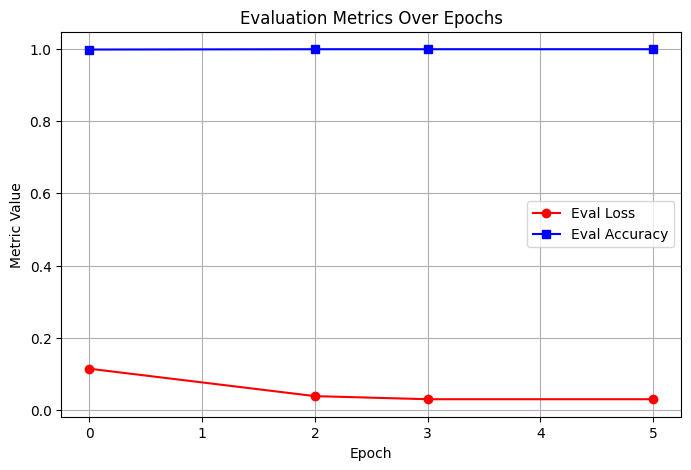

In [38]:
log_history = trainer.state.log_history

epochs = []
eval_losses = []
eval_accuracies = []


for i, log in enumerate(log_history):
    if "eval_loss" in log:
        epochs.append(i)
        eval_losses.append(log["eval_loss"])
        if "eval_accuracy" in log:
            eval_accuracies.append(log["eval_accuracy"])


plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_losses, label="Eval Loss", marker='o', color='red')


if eval_accuracies:
    plt.plot(epochs[:len(eval_accuracies)], eval_accuracies, label="Eval Accuracy", marker='s', color='blue')

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics Over Epochs")
plt.legend()
plt.grid()

plt.show()

In [39]:
output_dir = "../../models/wav2vec2/"

trainer.save_model(output_dir)

processor.save_pretrained(output_dir)

[]